# Importing Data 

In [1]:
import numpy as np
import os
from scipy import signal
import UDIP_Lib_V19 as UDIP_Lib  #Makes updating UDIP_Lib easier
import RockSat_1_14_fitting_functions as R_fitting
import json
import matplotlib.pyplot as plt
from RockSat_json import *
import UDIP_Fitting as UD_fit    #Josh's version
import math

In [2]:
year = 2021
#packets = import_data(f'../{year}/{year}_packet.json')
packets = import_data(f'{year}_packet.json')

# Get Sweep Function and Saving Figures

In [3]:
def get_sweep(sw, cn = 0):

  sec = np.linspace(0, 1, 5)

  start = sw['Start']
  stop =  sw['Stop']

  sw['Voltage'] = np.array(sw['Voltage'])
  sw[f'Current{cn}'] = np.array(sw[f'Current{cn}'])

  V1 = sw['Voltage']     [0: int(sec[1] * len(sw['Voltage' ]))]
  I1 = sw[f'Current{cn}'][0: int(sec[1] * len(sw[f'Current1']))]

  V2 = sw['Voltage']     [int(sec[1]*len(sw['Voltage' ]))      :int(sec[2]*len(sw['Current1'])) ]
  I2 = sw[f'Current{cn}'][int(sec[1]*len(sw[f'Current{cn}']))  :int(sec[2]*len(sw['Current1'])) ]

  V3 = sw['Voltage']     [int(sec[2]*len(sw['Voltage' ]))      :int(sec[3]*len(sw['Current1'])) ]
  I3 = sw[f'Current{cn}'][int(sec[2]*len(sw[f'Current{cn}']))  :int(sec[3]*len(sw['Current1'])) ] 

  V4 = sw['Voltage']     [int(sec[3]*len(sw['Voltage' ]))      :int(sec[4]*len(sw['Current1'])) ]
  I4 = sw[f'Current{cn}'][int(sec[3]*len(sw[f'Current{cn}']))  :int(sec[4]*len(sw['Current1'])) ]

  Vf = sw['Voltage']     [int(sec[1]*len(sw['Voltage' ]))      :int(sec[3]*len(sw['Current1'])) ]
  If = sw[f'Current{cn}'][int(sec[1]*len(sw[f'Current{cn}']))  :int(sec[3]*len(sw['Current1'])) ]
  return start, stop, V1, I1, V2, I2, V3, I3, V4, I4

In [4]:
sw_range = np.arange(0,int(len(packets['packets']['Medium'])), 100) 

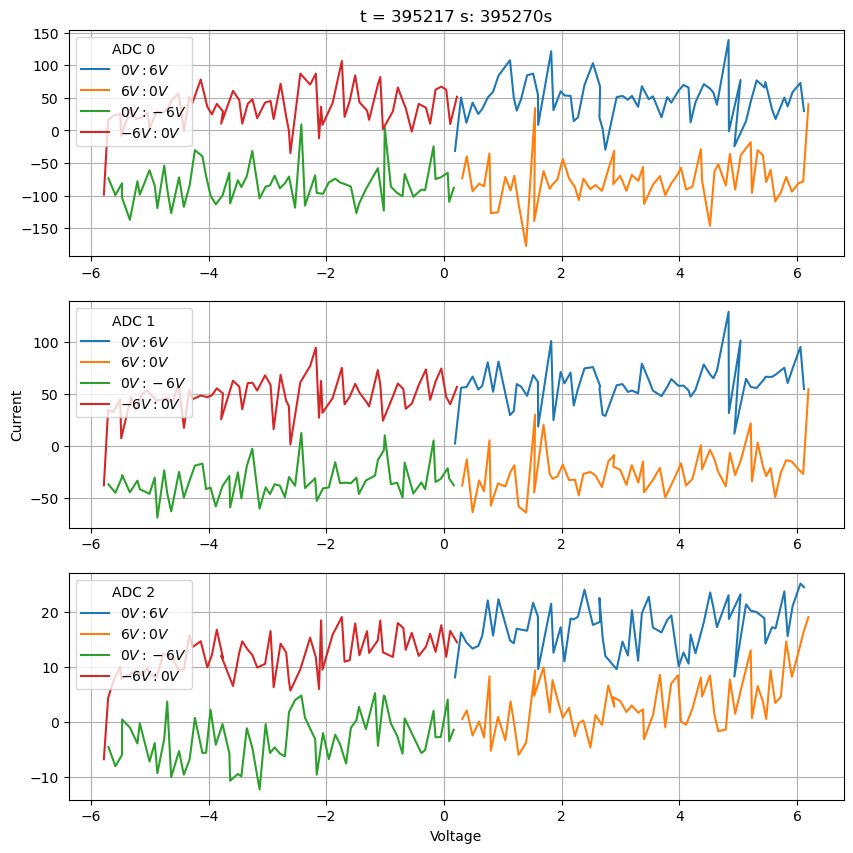

In [5]:
cn = 0
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
for i in sw_range:
  for axnum in np.arange(len(axs)):
    axs[axnum].clear()
    cn = axnum
    start, stop, V1, I1, V2, I2, V3, I3, V4, I4 = get_sweep(packets['packets']['Medium'][f'{i}'], cn = cn)

    axs[axnum].plot(V1, I1 , label = r'$ 0V : 6V$')
    axs[axnum].plot(V2, I2 , label = r'$ 6V:  0V$')
    axs[axnum].plot(V3, I3 , label = r'$ 0V: -6V$')
    axs[axnum].plot(V4, I4 , label = r'$-6V : 0V$')
    axs[axnum].legend(title = f'ADC {cn}', loc = 'upper left')
    axs[axnum].grid()
  axs[0].set_title(f't = {start} s: {stop}s')
  axs[2].set_xlabel('Voltage')
  axs[1].set_ylabel('Current')
  #plt.savefig(f'../{year}/Sweeps/sw_{i}.jpg' , dpi = 400) 

# Testing the Fitting Functions

In [6]:
V = packets['packets']['Medium']['1400']['Voltage']
I = packets['packets']['Medium']['1400']['Current0']

x, y, popt, pcov = R_fitting.gen_fit(np.array(V), np.array(I)) # x is V, y is I
print(popt) #popt[0:xa,1:b,2:m1,3:n,4:t,5:V0] from rocksat fitting functions

[ 5.95224990e-01  3.93532158e+01  2.24698867e+02  6.68848635e+10
  9.94907487e+02 -5.06059981e-01]


### Is it a good fit?

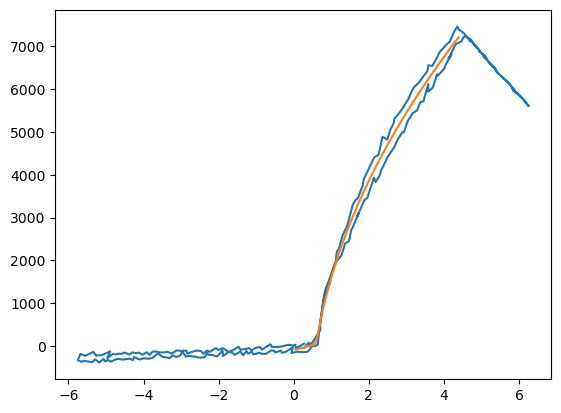

In [7]:
plt.plot(V,I)
plt.plot(x,y)

# Ne and Te on each IV Curve

c:\Users\catal\DAPPEr\2021\RockSat_1_14_fitting_functions.py:45: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1. + k*(x + V0))
C:\Users\catal\AppData\Local\Temp\ipykernel_26724\2433984824.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


ValueError: `ydata` must not be empty!

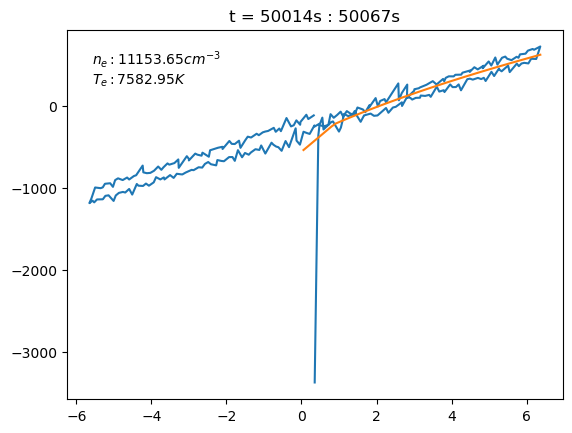

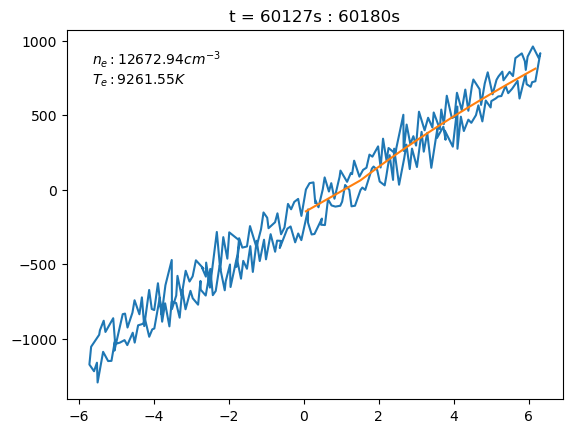

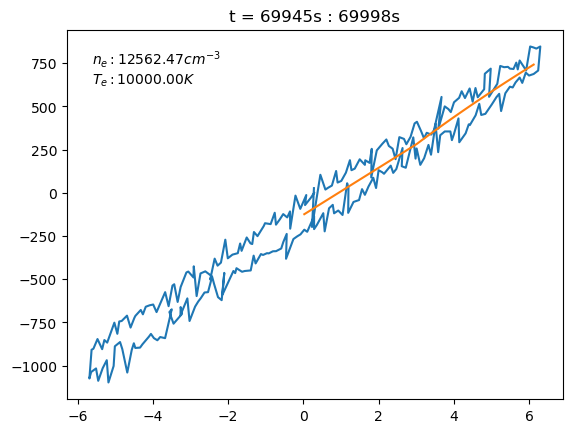

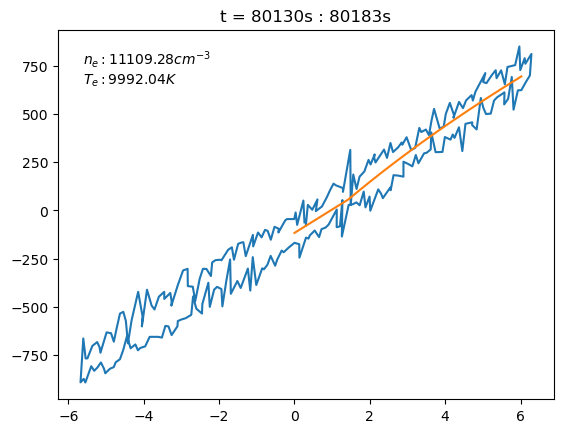

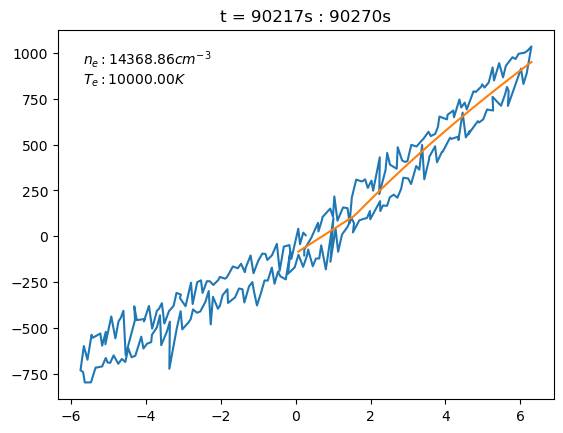

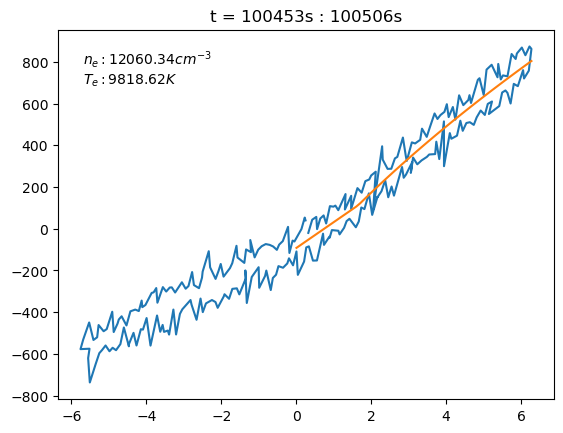

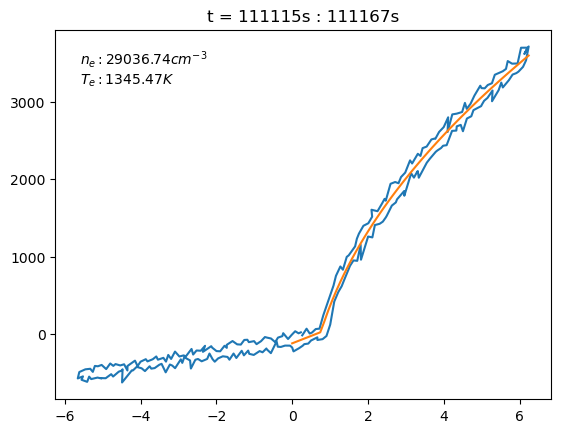

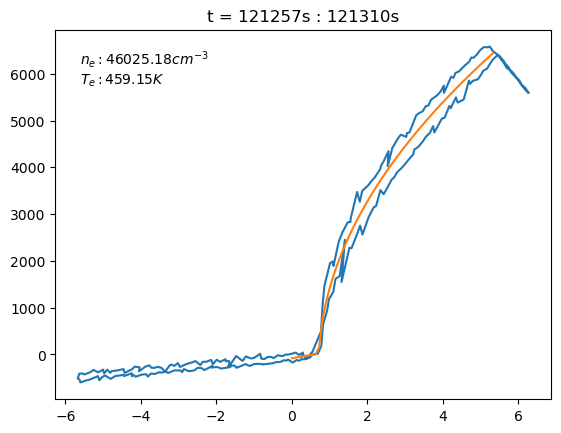

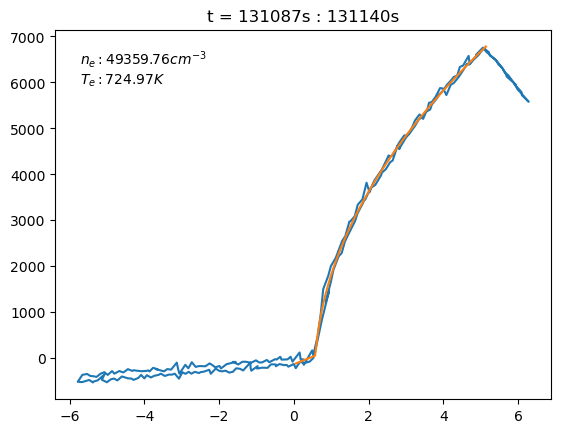

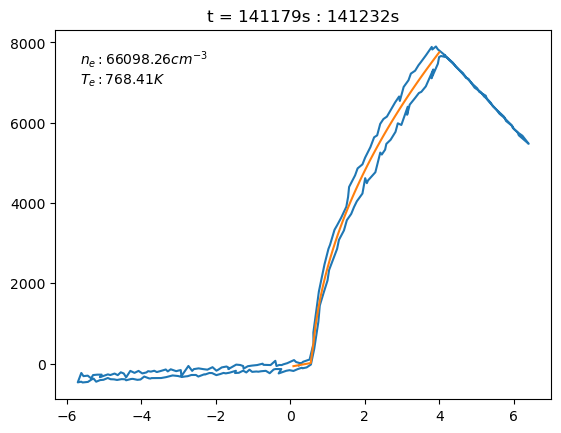

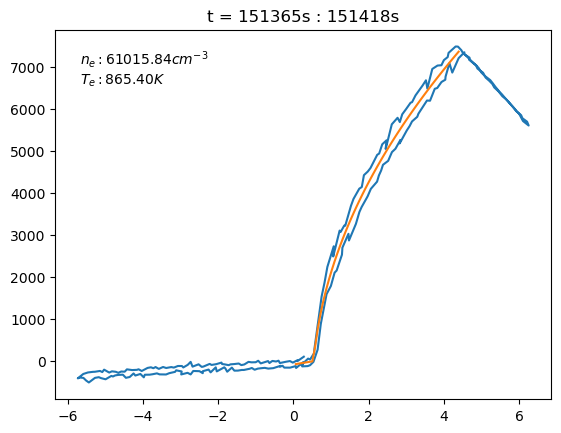

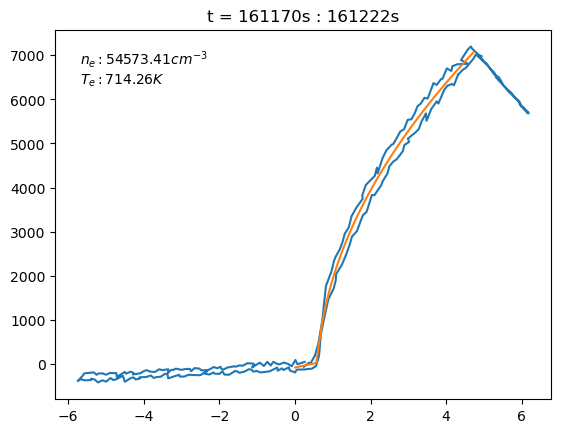

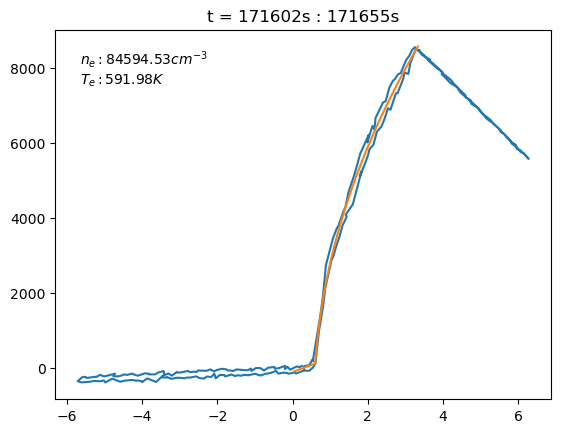

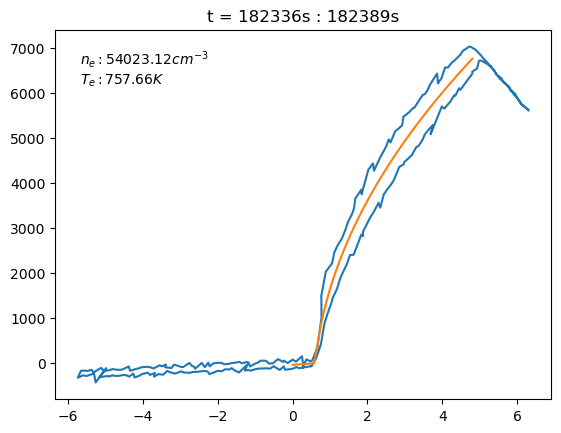

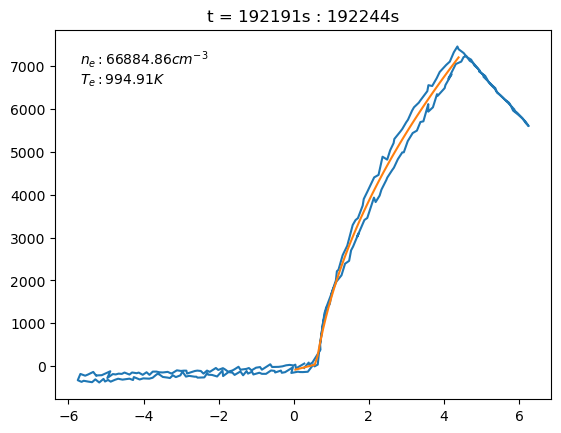

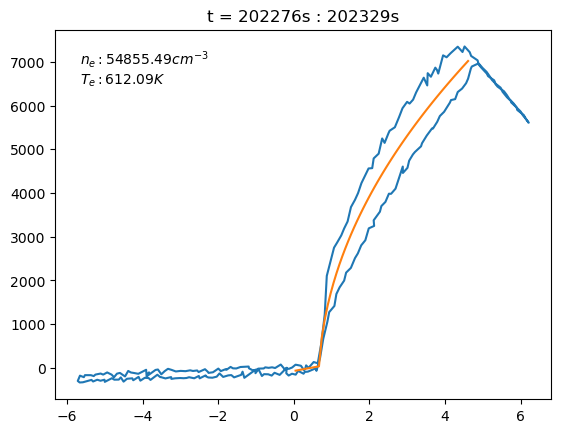

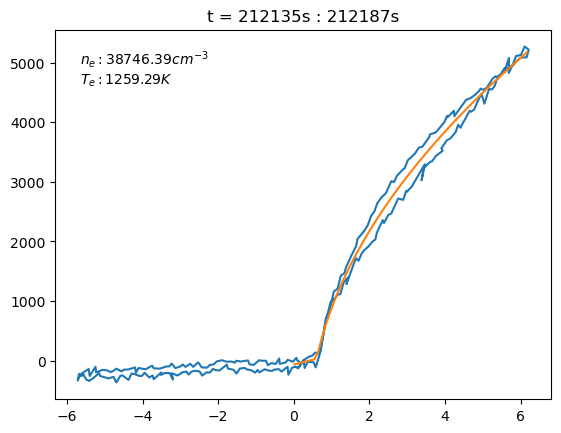

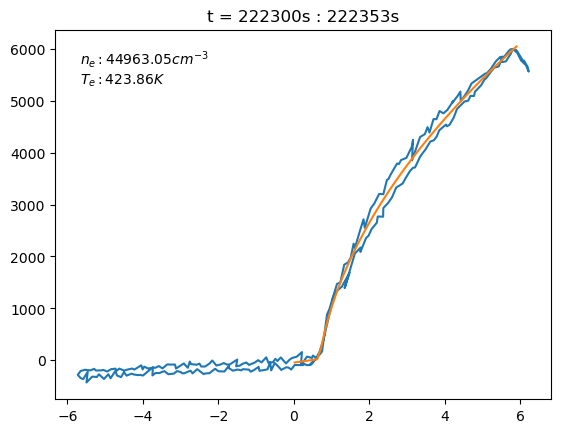

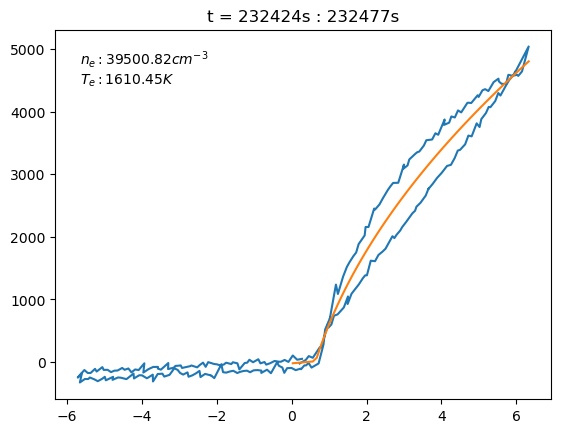

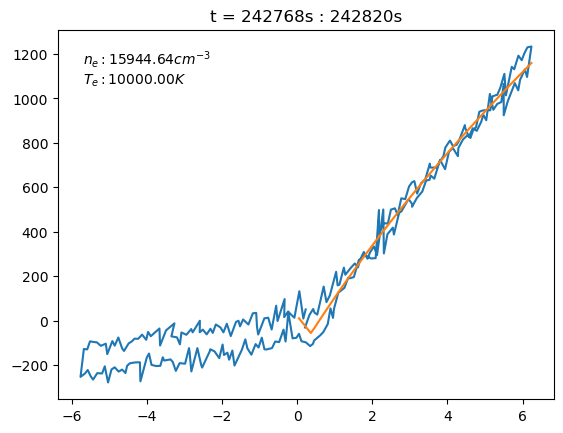

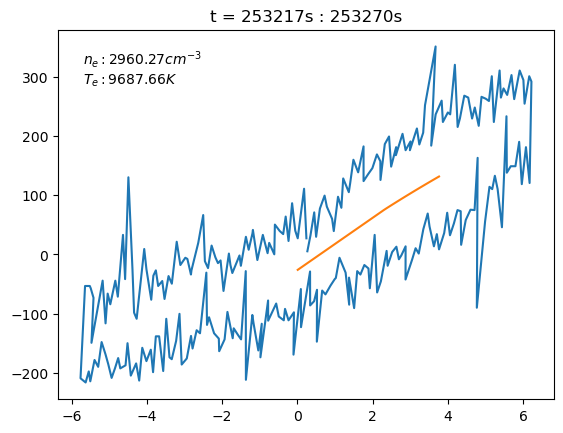

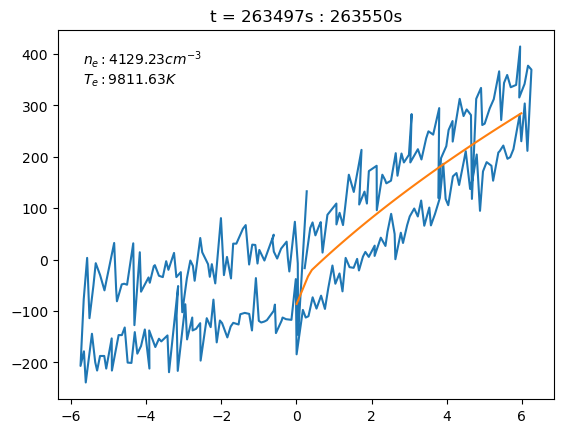

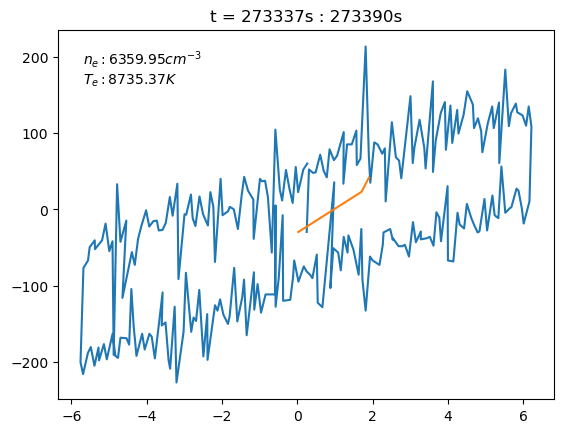

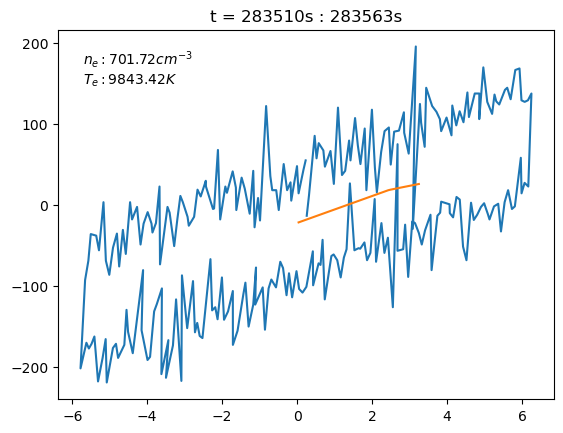

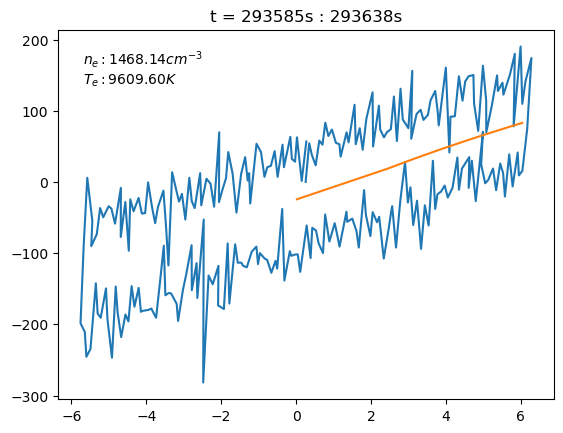

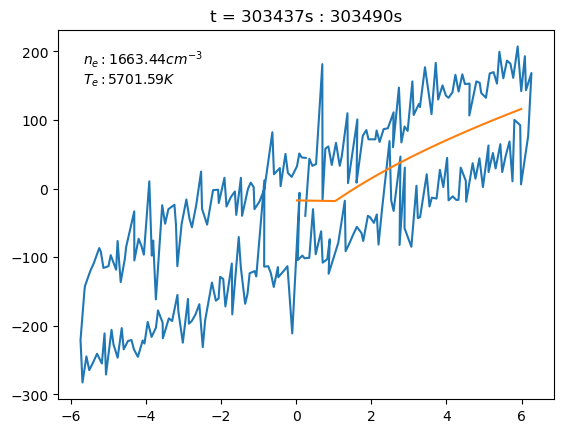

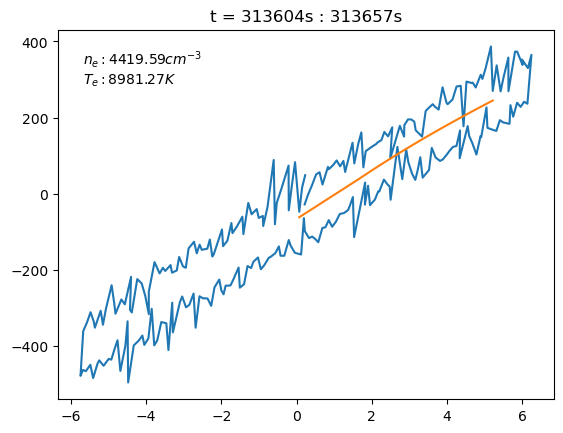

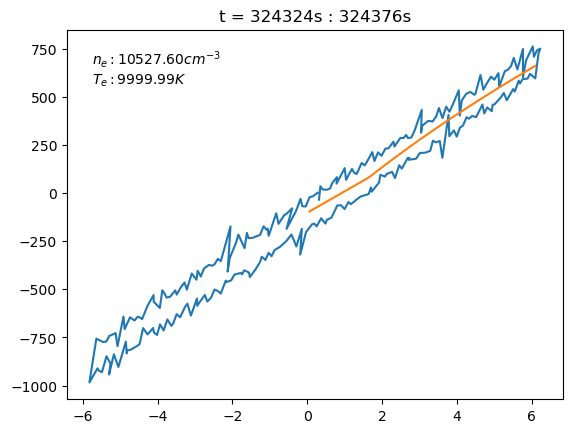

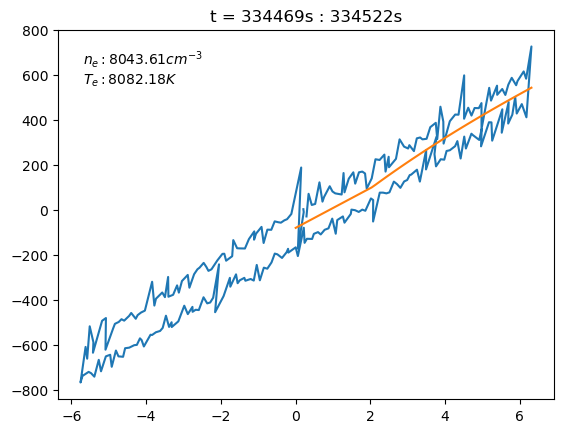

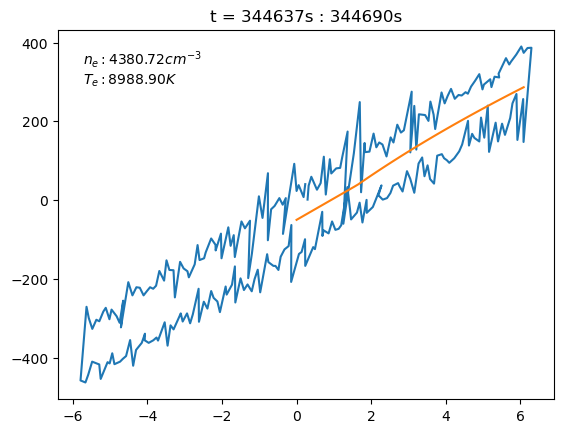

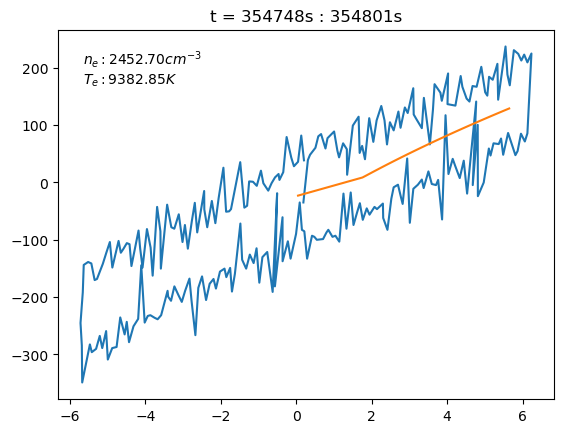

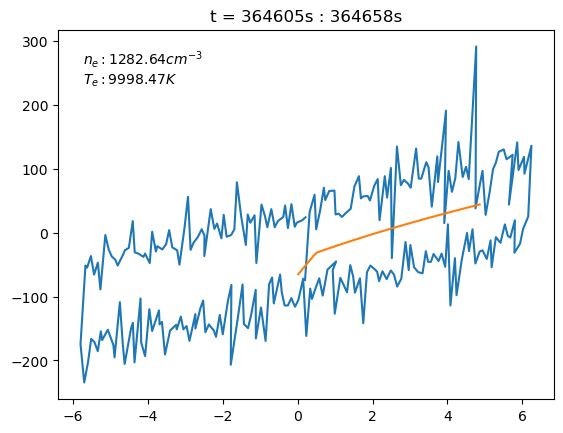

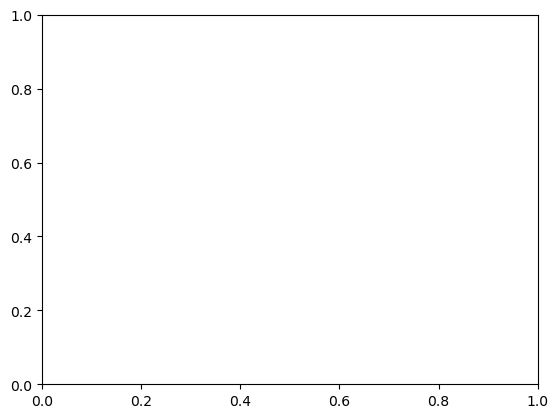

In [8]:
for i in sw_range:
  fig, ax = plt.subplots()

  V = packets['packets']['Medium'][f'{i}']['Voltage']
  I = packets['packets']['Medium'][f'{i}']['Current0']
  x, y, popt,pcov = R_fitting.gen_fit(np.array(V), np.array(I))
  start, stop, V1, I1, V2, I2, V3, I3, V4, I4 = get_sweep(packets['packets']['Medium'][f'{i}'], cn = cn) # To get the times


  ne = popt[3] * 10**(-6) # To convert into cm^-3
  Te = popt[4]

  textstr = '\n'.join((
    r'$n_e:%.2f cm^{-3}$' % (ne, ),
    r'$T_e:%.2f K$' % (Te, )))
  
  ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10, verticalalignment='top')

  ax.plot(V, I)
  ax.plot(x,y)
  ax.set_title(f't = {start}s : {stop}s')
  
  #plt.savefig(f'../Testing/sw_{i}.jpg' , dpi = 400) 

# Ne vs Time and Te vs Time

In [9]:
sw_tot = np.arange(0,int(len(packets['packets']['Medium']))) #Every single sweep

In [10]:
ne_tot = []
te_tot = []
t = []
for i in sw_tot:
    V = packets['packets']['Medium'][f'{i}']['Voltage']
    I = packets['packets']['Medium'][f'{i}']['Current0']
    x, y, popt,pcov = R_fitting.gen_fit(np.array(V), np.array(I))
    start, stop, V1, I1, V2, I2, V3, I3, V4, I4 = get_sweep(packets['packets']['Medium'][f'{i}'], cn = cn)

    ne = popt[3] * 10**(-6) # To convert into cm^-3
    te = popt[4]

    ne_tot.append(ne)
    te_tot.append(te)
    t.append(start)

ValueError: `ydata` must not be empty!

Text(0, 0.5, '$n_e \\: cm^{-3}$')

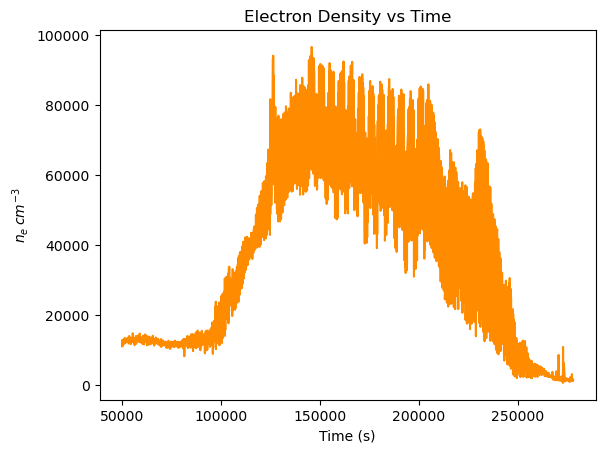

In [12]:
plt.plot(t, ne_tot, color = 'darkorange')
plt.title("Electron Density vs Time")
plt.xlabel("Time (s)")
plt.ylabel("$n_e \: cm^{-3}$")

Text(0, 0.5, 'Electron Temperature (K)')

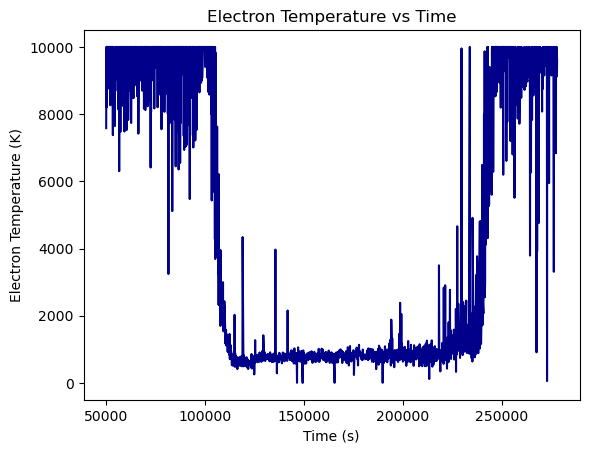

In [11]:
plt.plot(t,te_tot, color = 'darkblue')
plt.title("Electron Temperature vs Time")
plt.xlabel("Time (s)")
plt.ylabel("Electron Temperature (K)")

# Error vs Number of Points

In [13]:
V = packets['packets']['Medium']['1700']['Voltage']   #length is 265, goes up to index 264
I = packets['packets']['Medium']['1700']['Current0']

x, y, popt, pcov = UD_fit.gen_fit(V, I) #length of x1 and y1 is 200

c:\Users\catal\DAPPEr\2021\UDIP_Fitting.py:98: RuntimeWarning: invalid value encountered in sqrt
  return I0 * np.sqrt(1. + k*(x + VP))


### Functions

In [17]:
def round_up(n, decimals=0):
    multiplier = 10**decimals
    return int(math.ceil(n * multiplier) / multiplier )  #returns an integer

#Comparing round with math.ciel()
print(round_up((265/2)))    #Note: 265/2 = 135.5
print(round(265/2))

133
132


Notes for num_list():
* Issue: As you get closer to 265, the skips (last input) either become 1 or 2, so it is more accurate for a smaller number of points
* VERY rough estimate

In [15]:
def num_list(x, y, num_points): #num_points >= 1
    nx = x[:: int(math.ceil(265 / num_points)) ]    #math.ciel() function rounds up to the nearest integer
    ny = y[:: int(math.ceil(265 / num_points)) ]
    
    return nx, ny #new x and new y (smaller list)

Note: I will change error() function in the near future to become more general

In [16]:
def error(ogfit, newfit):
    diff = abs ((ogfit/ newfit) - 1)
    avg = 0
    for i in diff:
        avg = avg + i 
    error = avg / 200  #gen_fit() gives 200 points every time
    return error

### Plotting the average error between the gen_fit of the original data and of the extracted data with fewer points

In [ ]:
error_list = []
rn = [] #rough estimate of the number of points

for i in range(3, round_up(265 / 2)):
    fig, ax = plt.subplots()
    
    x1, y1, popt, pcov = UD_fit.gen_fit(num_list(V, I, i)[0], num_list(V, I, i)[1])
    error_list.append(error(y, y1)) #y is for the og data, y1 is for the extracted data
    rn.append(i)
    
    #Visual of the plots - uncomment for lots of graphs
    
    #ax.plot(V,I) 
    #ax.plot(num_list(V, I, i)[0], num_list(V, I, i)[1]) 
    #plt.xlabel("Voltage (V)")
    #plt.ylabel("Current")
    #plt.legend(["Sweep 1700","Number of Points: "+f'{i}'])

    #plt.savefig(f'../Error Plots/num_points_{i}.jpg' , dpi = 400)

**Q:**  Why check the number of actual points?
* Doing this backs up an earlier comment about num_list(). It works well for a small number of points, however, it begins to be inaccurate once the num_points becomes large. 
    * This means that there is a discrepancy of number of points as we go up
* In the future, instead of using the number of points, we will be using fractions of the data. This will hopefully help eliminate this issue.

In [19]:
#Highlight: (okayish) 30, (good) 50, (best) 89 
print("Actual Number of Points: ", len(num_list(V, I, 30)[0]))  #num_points_30
print("Actual Number of Points: ", len(num_list(V, I, 50)[0]))  #num_points_50
print("Actual Number of Points: ", len(num_list(V, I, 80)[0]))  #num_points_80

Actual Number of Points:  30
Actual Number of Points:  45
Actual Number of Points:  67


Notes:
* Begins at 3 points to avoid outliers of 400 error
    * You can try it yourself by changing the starting value for the range to be 0 instead of 3
* Flat lines in some segments are from the problem with my num_points() function

Text(0.5, 1.0, 'Number of Points vs Average Error for gen_fit()')

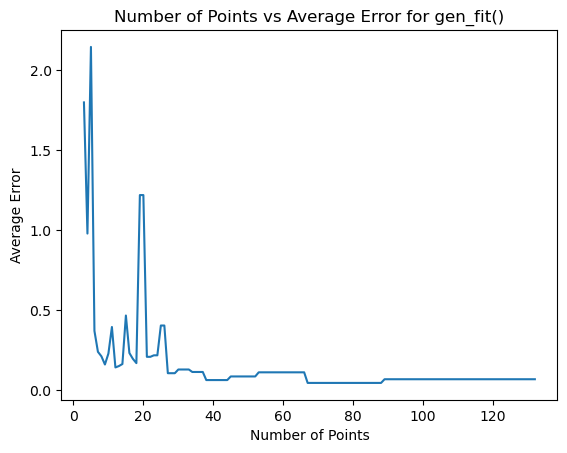

In [20]:
plt.plot(rn, error_list)
plt.xlabel("Number of Points")
plt.ylabel("Average Error") #Error between gen_fit() of original V and I and of the shortened version
plt.title("Number of Points vs Average Error for gen_fit()")